In [ ]:
import os
import torch

In [ ]:
data_dir = os.path.join('/data2', 'EgoExo4D')
features_dir = os.path.join(data_dir, 'features', 'omnivore_video')
file_id = '1656ad38-2a4d-4561-a077-a646e24812a4_aria01_rgb.pt'

In [ ]:
file = torch.load(os.path.join(features_dir, file_id))

In [ ]:
file.shape

# VRS file

In [ ]:
import os

ego_exo_root = os.path.join('/data2', 'EgoExo4D') # Replace with your cli's download directory for Ego-Exo4D
take_name = 'cmu_bike01_5'

ego_exo_project_path = os.path.join(ego_exo_root, 'takes', take_name)
print(f'EgoExo Sequence: {ego_exo_project_path}')

if not os.path.exists(ego_exo_project_path):
    print("Please do update your path to a valid EgoExo sequence folder.")

In [ ]:
from projectaria_tools.core import data_provider

vrs_file_path = os.path.join(ego_exo_project_path, 'aria01_noimagestreams.vrs')
print(vrs_file_path)
assert os.path.exists(vrs_file_path), "We are not finding the required vrs file"

vrs_data_provider = data_provider.create_vrs_data_provider(vrs_file_path)
if not vrs_data_provider:
    print("Couldn't create data vrs_data_provider from vrs file")
    exit(1)

In [ ]:
from projectaria_tools.core.stream_id import StreamId
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from tqdm import tqdm
import numpy as np

###
# We are demonstrating here how to retrieve the time stamp of a given stream
# - and how to retrieve 10 frames along this time span
###

# rgb_stream_id = StreamId("214-1")
slam_left_stream_id = StreamId("1201-1")
slam_right_stream_id = StreamId("1201-2")
# rgb_stream_label = vrs_data_provider.get_label_from_stream_id(rgb_stream_id)
slam_left_stream_label = vrs_data_provider.get_label_from_stream_id(slam_left_stream_id)
slam_right_stream_label = vrs_data_provider.get_label_from_stream_id(slam_right_stream_id)

# Init rerun api
# rr.init("Aria Data Provider - Retrieve Image Stream data")
# rec = rr.memory_recording()

# Configure option for data retrieval
time_domain = TimeDomain.DEVICE_TIME  # query data based on host time
option = TimeQueryOptions.CLOSEST # get data whose time [in TimeDomain] is CLOSEST to query time
# vrs_data_provider.get_imu_data_by_time_ns()
# Retrieve Start and End time for the given Sensor Stream Id
start_time = vrs_data_provider.get_first_time_ns(slam_left_stream_id, time_domain)
end_time = vrs_data_provider.get_last_time_ns(slam_left_stream_id, time_domain)

# FYI, you can retrieve the Image configuration using the following
image_config = vrs_data_provider.get_image_configuration(slam_left_stream_id)
width = image_config.image_width
height = image_config.image_height
print(f"StreamId {slam_left_stream_id}, StreamLabel {slam_left_stream_label}, ImageSize: {width, height}")

sample_count = 10
sample_timestamps = np.linspace(start_time, end_time, sample_count)

In [ ]:
stream_id = vrs_data_provider.get_stream_id_from_label("imu-left")

accl = []
gyro = []
ts_ns = []

for index in range(0, int(vrs_data_provider.get_num_data(stream_id) / 10)):

    imu_data = vrs_data_provider.get_imu_data_by_index(stream_id, index)
    timestamp = imu_data.capture_timestamp_ns
    ts_ns.append(timestamp)
    accl.append(imu_data.accel_msec2),
    gyro.append(imu_data.gyro_radsec)

In [ ]:
len(accl), len(gyro), len(ts_ns)

In [ ]:
vrs_data_provider.get_num_data(stream_id)

In [ ]:
start_time = vrs_data_provider.get_first_time_ns(stream_id, time_domain)
end_time = vrs_data_provider.get_last_time_ns(stream_id, time_domain)

In [ ]:
(start_time / 1e9, end_time / 1e9)

# Takes metadata

In [ ]:
import json
import os

# Load the json file
# takes = pd.read_json(os.path.join(ego_exo_root, 'takes.json'))
ego_exo_root = os.path.join('/data2', 'EgoExo4D') # Replace with your cli's download directory for Ego-Exo4D
data_dir = os.path.join('/data2', 'EgoExo4D')
takes = json.load(open(os.path.join(ego_exo_root, 'takes.json')))

In [ ]:
takes[0]

In [ ]:
from projectaria_tools.core.stream_id import StreamId
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from tqdm import tqdm
import numpy as np


def get_take_vrs_file(take_root_dir: os.PathLike):
    '''
    Get both IMU streams from the VRS file
    '''
    from projectaria_tools.core import data_provider

    # Get the VRS file
    vrs_file_path = os.path.join(take_root_dir, 'aria01_noimagestreams.vrs')
    assert os.path.exists(vrs_file_path), "We are not finding the required vrs file"

    # Create the VRS data provider
    vrs_data_provider = data_provider.create_vrs_data_provider(vrs_file_path)
    if not vrs_data_provider:
        # print("Couldn't create data vrs_data_provider from vrs file")
        exit(1)
    
    return vrs_data_provider

def get_imu_data(vrs_data_provider, stream_labels: list[str]):
    '''
    Get both IMU streams from the VRS file.

    Args:
    - vrs_data_provider: the VRS data provider
    - stream_labels: the labels of the streams to retrieve. ['imu-left', 'imu-right']

    '''
    stream_id = vrs_data_provider.get_stream_id_from_label(stream_labels[0])
    assert stream_id, f"Couldn't find stream id for {stream_labels[0]}"

    '''
    For each stream, we will get the IMU data for a total of 7 columns:
    - timestamps (in ns)
    - accelerometer data (in m/s^2) (x, y, z)
    - gyroscope data (in rad/sec) (x, y, z)
    '''
    left = np.zeros((vrs_data_provider.get_num_data(stream_id), 7))
    right = np.zeros((vrs_data_provider.get_num_data(stream_id), 7))

    for idx, stream_label in enumerate(stream_labels):
        stream_id = vrs_data_provider.get_stream_id_from_label(stream_label)

        for index in range(int(vrs_data_provider.get_num_data(stream_id))):
            imu_data = vrs_data_provider.get_imu_data_by_index(stream_id, index)
            timestamp = imu_data.capture_timestamp_ns
            try:
                if stream_label.endswith('left'):
                    left[index, 0] = timestamp
                    left[index, 1:4] = imu_data.accel_msec2
                    left[index, 4:] = imu_data.gyro_radsec
                else:
                    right[index, 0] = timestamp
                    right[index, 1:4] = imu_data.accel_msec2
                    right[index, 4:] = imu_data.gyro_radsec
            except:
                "skipping"

    return left, right

In [ ]:
from tqdm.auto import tqdm

missing_files = []
imu_path = os.path.join(data_dir, 'features', 'imu_aria01')
print("start")
for idx, take in enumerate(tqdm(takes, total=len(takes))):
    take_vrs_path = os.path.join(data_dir ,take['root_dir'])
    try:
        data_provider = get_take_vrs_file(take_vrs_path)
        # left, right = get_imu_data(data_provider,['imu-left', 'imu-right'])
        _, right = get_imu_data(data_provider,['imu-right'])
        take_name = take['take_name']
        path_take = os.path.join(imu_path, f"{take_name}")
        if not os.path.exists(path_take):
            os.makedirs(path_take)
        # np.save(os.path.join(path_take, 'left.npy'), left)
        np.save(os.path.join(path_take, 'right.npy'), right)

    except:
        missing_files.append(take_vrs_path)
        continue

In [ ]:
left.shape, right.shape

In [ ]:
prova_left, prova_right = left[0,0] / 1e9, right[0,0] / 1e9
prova_left, prova_right = prova_left.round(4), prova_right.round(4)
prova_left, prova_right

In [ ]:
right = right.T

In [ ]:
(right[0,-1] - right[0,0]) / 1e9

In [ ]:
missing_files

In [ ]:
print('Missing takes: ', len(missing_files))
missing_files_path = os.path.join('../data', 'EgoExo4D', 'missing_files.npy')
os.makedirs(os.path.dirname(missing_files_path), exist_ok=True)
np.save(missing_files_path, missing_files)

# Create Pretraining metadata with omnivore

In [3]:
import json
import os
import numpy as np
import pickle as pkl
import torch
from tqdm.auto import tqdm

# Load the json file
# takes = pd.read_json(os.path.join(ego_exo_root, 'takes.json'))
ego_exo_root = os.path.join('/data2', 'EgoExo4D') # Replace with your cli's download directory for Ego-Exo4D
data_dir = os.path.join('/data2', 'EgoExo4D')
takes = json.load(open(os.path.join(ego_exo_root, 'takes.json')))
# missing_files = np.load(os.path.join('../data', 'EgoExo4D', 'missing_files.npy'))
missing_files = pkl.load(open(os.path.join('../data', 'EgoExo4D', 'missing_files.pkl'), 'rb'))

In [9]:
annotations_pretrain = []

features_path = os.path.join(data_dir, 'features')
print("start")
for idx, take in enumerate(tqdm(takes, total=len(takes))):
    if take['root_dir'].split('/')[1] in missing_files:
        print(f"Skipping {take['root_dir']}: missing file.")
        continue
    
    if take['task_timing_annotation_uid'] is None:
        print(f"Skipping {take['root_dir']}: missing task timing annotation.")
        continue

    take_imu_path = os.path.join(features_path,'imu_aria01', take['take_name'])
    start_sec = take['task_start_sec']
    end_sec = take['task_end_sec']
    take_duration = take['duration_sec']
    effective_duration = end_sec - start_sec

    omnivore_file = torch.load(os.path.join(features_path, 'omnivore_video', f"{take['take_uid']}_aria01_rgb.pt"))
    num_frames = omnivore_file.shape[0]

    print(f"Take: {take['take_name']}, Duration: {take_duration}, NumFrames: {num_frames}")
    print(f"Start: {start_sec}, End: {end_sec}, Subtract: {end_sec - start_sec}")
    for frame in range(0, num_frames):
        start_s = 16/30 * frame
        end_s = start_s + 16/30

        if frame == len(omnivore_file) - 1 and end_s > end_sec:
            start_s = end_sec - 16/30
            end_s = end_sec

        annotations_pretrain.append({
            'take_name': take['take_name'],
            'take_uid': take['take_uid'],
            'start_sec': start_s,
            'end_sec': end_s,
            'omnivore_idx': frame
        })

pkl.dump(annotations_pretrain, open(os.path.join('../data', 'EgoExo4D', 'annotations_pretrain.pkl'), 'wb'))

start


  0%|          | 0/5035 [00:00<?, ?it/s]

Take: cmu_bike01_2, Duration: 110.93333333333334, NumFrames: 207
Start: 0.28164, End: 110.06668, Subtract: 109.78504000000001
Take: cmu_bike01_4, Duration: 111.23333333333333, NumFrames: 208
Start: 0.20069, End: 110.66667, Subtract: 110.46598
Take: cmu_bike01_5, Duration: 155.5, NumFrames: 291
Start: 0.29999, End: 155.16667, Subtract: 154.86668
Take: cmu_bike01_7, Duration: 143.1, NumFrames: 268
Start: 0.2617, End: 141.11243, Subtract: 140.85073
Take: cmu_bike02_2, Duration: 130.1, NumFrames: 243
Start: 0.34598, End: 129.73334, Subtract: 129.38736
Take: cmu_bike02_3, Duration: 201.36666666666667, NumFrames: 377
Start: 0.40907, End: 197.94994, Subtract: 197.54086999999998
Take: cmu_bike02_4, Duration: 3.6666666666666665, NumFrames: 6
Start: 0.47171, End: 3.33334, Subtract: 2.8616300000000003
Take: cmu_bike02_5, Duration: 75.36666666666666, NumFrames: 141
Start: 0.22676, End: 75.06667, Subtract: 74.83991
Take: cmu_bike02_6, Duration: 122.8, NumFrames: 230
Start: 0.24375, End: 122.6, Subt

In [10]:
len(annotations_pretrain)

1041057

In [59]:
annotations_pretrain[-1]

{'take_name': 'cmu_bike01_2',
 'take_uid': 'ed3ec638-8363-4e1d-9851-c7936cbfad8c',
 'start_sec': 109.53334666666667,
 'end_sec': 110.06668,
 'omnivore_idx': 206}

In [53]:
n = 0
start, end = 16 / 30 * n, 16 / 30 * n + 32/30
start, end, end - start

(0.0, 1.0666666666666667, 1.3483066666666668)

# Investigate spectrograms

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torchaudio
import librosa
import torchaudio.transforms as T
import torch

In [2]:
data_dir = os.path.join('/data2', 'EgoExo4D', 'features', 'imu_aria01', 'cmu_bike01_5')
data = np.load(os.path.join(data_dir, 'right.npy')).T

In [3]:
data.shape

(7, 155368)

In [4]:
diff = np.round(np.diff(data[0, :]) / 1e9, 3)
max(diff), min(diff)

(0.001, 0.001)

In [5]:
data_rounded = data
data_rounded[0, :] = np.round(data[0, :] / 1e9, 3)

In [6]:
data_tensor = torch.tensor(data_rounded[1:, :])

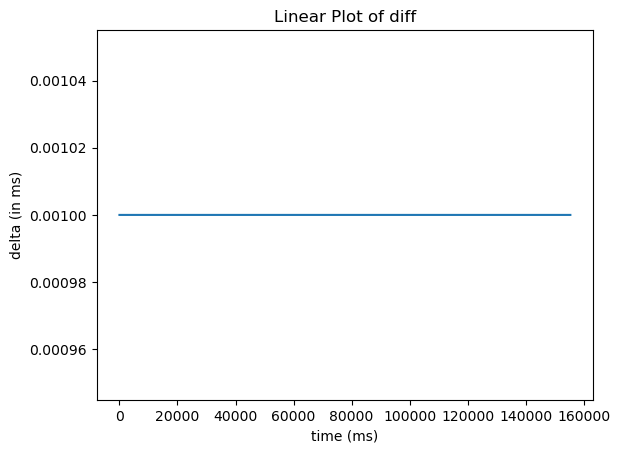

In [7]:
plt.plot(diff)
plt.title('Linear Plot of diff')
plt.xlabel('time (ms)')
plt.ylabel('delta (in ms)')
plt.show()

In [ ]:
sample_rate * seconds

In [8]:
seconds = 2
sample_rate = 1e3
start = 500
windowed_data = data_tensor[:, start:int(start + seconds * sample_rate)]
windowed_data.shape

torch.Size([6, 2000])

In [9]:
windowed_data.max(), windowed_data.min()

(tensor(13.5464, dtype=torch.float64), tensor(-9.7013, dtype=torch.float64))

In [10]:
def normalize_tensor(tensor):
    tensor = torch.from_numpy(tensor)
    min_value = torch.min(tensor)
    max_value = torch.max(tensor)
    normalized_tensor = (tensor - min_value) / (max_value - min_value)
    return normalized_tensor

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

In [ ]:
SPECGRAM_PARAMS = {
    'window_size': 2,
    'n_fft': 128,
    'hop_length': 4,
    'sampling_rate': 1e3,
    'downsampling_rate': 500,
    'transforms': None,
    'resizes': (64, 192), # patch_size=16 -> (4, 12) = 48 | patch_size=8 -> (8, 24) = 192
}

In [ ]:
prova_2s = torchaudio.functional.resample(windowed_data, 1e3, 500)
# prova_2s = accl_x_interp_torch
# prova_2s = normalize_tensor(prova_2s.numpy())
# 

n_ffts = [128, 256]
hop_length = [2, 4, 8, 16]
amplitude_to_db = T.AmplitudeToDB(stype="power", top_db=90)
specs = []
for i, n_fft in enumerate(n_ffts):
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        hop_length=4,
        center=True,
        pad_mode="reflect",
        power=2.0,
        normalized=True,
        window_fn=torch.signal.windows.nuttall
    )
    spectrogram.double()

    # 1. spettrogramma
    # 2. da amplitude a dB
    # 3. normalizzare [0,1]
    prova = spectrogram(prova_2s)
    # prova = librosa.power_to_db(prova)
    prova = amplitude_to_db(prova)
    # prova = normalize_tensor(prova.numpy())
    specs.append(prova)
    
for i in range(len(specs)):
    print(specs[i].shape) 

In [ ]:
fig, axs = plt.subplots(1, len(specs), figsize=(20,4))
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"{n_fft=}", ax=axs[i])
    axs[i].set_xlabel(None)

In [ ]:
windowed_data.shape

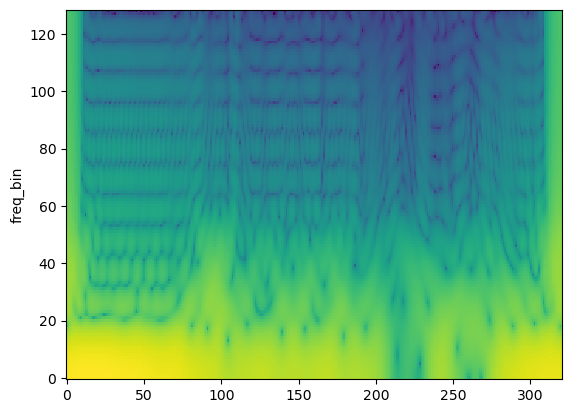

In [17]:
Fs = 50

waveform = windowed_data.type(torch.float32)
waveform = torchaudio.transforms.Resample(sample_rate, Fs)(waveform)
spectrogram_transform = torchaudio.transforms.Spectrogram(
            n_fft=256, 
            win_length=24,
            hop_length=1, 
            window_fn=torch.hann_window ,
        )

resample_ratio = 320/waveform.shape[1]
resample_target = int(100*resample_ratio)
waveform = torchaudio.transforms.Resample(100, resample_target)(waveform)
spectrogram = spectrogram_transform(waveform) # from [1,320] to [1,129,321]
spectrogram_db = torchaudio.transforms.AmplitudeToDB()(spectrogram)
fbank = spectrogram_db.squeeze(0).transpose(0,1)[:,:128]
plot_spectrogram(spectrogram_db[0], ylabel="freq_bin", ax=None)

In [ ]:
waveform

In [ ]:
spectrogram_db.shape

# EgoExo4D: Pytorch dataset class

In [11]:
%cd ..
%cd src

/home/gatanasio/SSPT_IMU
/home/gatanasio/SSPT_IMU/src


/home/gatanasio/miniconda3/envs/audio-mae/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [12]:
import os
import json
import pickle as pkl

from data.egoexo4d import EgoExo4D
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader

In [13]:
# Load the json file
# takes = pd.read_json(os.path.join(ego_exo_root, 'takes.json'))
ego_exo_root = os.path.join('/data2', 'EgoExo4D') # Replace with your cli's download directory for Ego-Exo4D
data_dir = os.path.join('/data2', 'EgoExo4D')
takes_path = os.path.join('../data', 'EgoExo4D', 'annotations_pretrain.pkl')

In [14]:
SPECGRAM_PARAMS = {
    'window_size': 2,
    'n_fft': 256,
    'win_length': 24,
    'hop_length': 1,
    'sampling_rate': 50,
    'transforms': None,
    'resizes': (128, 320),
    'temporal_points': 160
}

In [ ]:
dataset = EgoExo4D(data_dir, 'imu_aria01', ['imu-left', 'imu-right'], **SPECGRAM_PARAMS)